# Stage 2 : Pretraining and Foundation Model

## Training Loop

### Step 0 : Load the model architecture (from Stage 1)



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 1: Load Prepared Data from Stage 1, Step 1
print("Loading prepared data from Stage 1, Step 1...")
train_data, val_data, embedding_weights = torch.load("prepared_data_wiki.pth")

# Access the 'weight' tensor within the OrderedDict
embedding_weights_tensor = embedding_weights['weight']
vocab_size = embedding_weights_tensor.shape[0]  # Now use .shape on the tensor
embedding_dim = embedding_weights_tensor.shape[1]

print(f"Vocabulary Size: {vocab_size}")
print(f"Embedding Dimension: {embedding_dim}")

# Step 2: LayerNorm and GELU Activation
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x, 3))
        ))

# Step 3: FeedForward Network
class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim)
        )

    def forward(self, x):
        return self.net(x)

# Step 4: Multi-Head Attention Mechanism (Load Pretrained if Available)
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, value), attn_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        # Ensure head_dim is an integer by performing floor division
        self.head_dim = emb_dim // num_heads
        # Add assertion to ensure emb_dim is divisible by num_heads
        assert emb_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)
        self.fc_out = nn.Linear(emb_dim, emb_dim)

        self.attention = ScaledDotProductAttention()

        # Load pretrained weights if available
        if os.path.exists("attention_mechanism.pth"):
            print("Loading pretrained attention mechanism from 'attention_mechanism.pth'...")
            state_dict = torch.load("attention_mechanism.pth")

            # Update keys in the state dictionary to match current model
            # Create a new state dictionary with updated keys
            updated_state_dict = {}
            for k, v in state_dict.items():
                # Replace 'query_linear', 'key_linear', 'value_linear' with 'query', 'key', 'value'
                k = k.replace('query_linear', 'query').replace('key_linear', 'key').replace('value_linear', 'value')
                updated_state_dict[k] = v

            self.load_state_dict(updated_state_dict) # Load the updated state dictionary

        else:
            print("Pretrained attention mechanism not found, using default initialization.")

    def forward(self, x):
        batch_size, seq_len, emb_dim = x.shape
        q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attn_output, _ = self.attention(q, k, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, emb_dim)
        return self.fc_out(attn_output)

# Step 5: Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.attention = MultiHeadAttention(emb_dim, num_heads)
        self.norm1 = LayerNorm(emb_dim)
        self.ffn = FeedForward(emb_dim)
        self.norm2 = LayerNorm(emb_dim)

    def forward(self, x):
        attn_output = self.attention(self.norm1(x))
        x = x + attn_output
        ffn_output = self.ffn(self.norm2(x))
        return x + ffn_output

# Step 6: GPT Model (LLM Architecture)
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

        self.layers = nn.ModuleList([
            TransformerBlock(cfg["emb_dim"], cfg["n_heads"]) for _ in range(cfg["n_layers"])
        ])

        self.norm = LayerNorm(cfg["emb_dim"])
        self.fc_out = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        tok_emb = self.tok_emb(idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=idx.device))
        x = self.drop(tok_emb + pos_emb)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        logits = self.fc_out(x)
        return logits

# Step 7: Model Configuration
config = {
    "vocab_size": vocab_size,
    "context_length": 1024,
    "emb_dim": 256,
    "n_heads": 16,
    "n_layers": 16,
    "drop_rate": 0.1,
    "qkv_bias": False
}

model = GPTModel(config).to(device)
print("Model initialized successfully!")


Using device: cuda
Loading prepared data from Stage 1, Step 1...
Vocabulary Size: 100277
Embedding Dimension: 256
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pr

### Step 1 : Loading dataset

In [2]:
# Step 1: Loading dataset
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation data correctly (assuming it's part of the saved data)
train_data, val_data, embedding_weights = torch.load("prepared_data_wiki.pth")

# Now val_data should contain the actual validation data

# Pad sequences to the same length
train_data_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in train_data], batch_first=True, padding_value=0)  # Pad with 0
val_data_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in val_data], batch_first=True, padding_value=0)  # Pad with 0

# Create target data (shifted by one position)
train_targets_padded = train_data_padded[:, 1:]  # Targets are the next tokens in the sequence
val_targets_padded = val_data_padded[:, 1:]

# Add padding token to the end of target sequences
train_targets_padded = torch.cat([train_targets_padded, torch.zeros(train_targets_padded.shape[0], 1, dtype=torch.long)], dim=1)
val_targets_padded = torch.cat([val_targets_padded, torch.zeros(val_targets_padded.shape[0], 1, dtype=torch.long)], dim=1)

train_dataset = TensorDataset(train_data_padded, train_targets_padded) # Include target data
val_dataset = TensorDataset(val_data_padded, val_targets_padded) # Include target data

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Step 2

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

In [4]:
def top_k_sampling(logits, k):
    """Top-K sampling from logits."""
    values, indices = torch.topk(logits, k, dim=-1) # Apply top_k along the last dimension
    probs = torch.softmax(values, dim=-1)

    # Reshape probs to 2D for multinomial: (batch_size * seq_len, k)
    probs_2d = probs.view(-1, probs.size(-1))

    choice = torch.multinomial(probs_2d, 1)

    # Reshape choice back to original shape
    choice = choice.view(logits.size(0), logits.size(1), 1)

    # Gather selected indices
    selected_indices = torch.gather(indices, -1, choice).squeeze(-1)

    return selected_indices

def temperature_scaling(logits, temperature):
    """Apply temperature scaling to logits."""
    return logits / temperature

def cosine_decay_lr(step, warmup_steps, total_steps, initial_lr, min_lr):
    """Compute learning rate using warmup and cosine decay."""
    if step < warmup_steps:
        return initial_lr + step * (initial_lr - min_lr) / warmup_steps
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    cosine_lr = min_lr + (initial_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
    return cosine_lr

def calculate_loss(model, inputs, targets):
    """Calculate loss and perplexity."""
    outputs = model(inputs)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
    perplexity = torch.exp(loss)
    return loss, perplexity

### Step 3 : Training function

In [7]:
# need to run this cell if training is stopped and resumed next day

import math  # Import math for cosine function

# Change this for each epoch run for correct display in output
epoch_step = 2
# Default 1 means it will show Epoch 1 in the output
# Increase it for the next epoch

def train_model(model, train_loader, val_loader, optimizer, n_epochs, warmup_steps, initial_lr, min_lr,
                eval_freq=100, clip_value=1.0, k=5, temperature=1.0, accumulation_steps=2): # Added accumulation_steps

    train_losses, val_losses, lr_values = [], [], []
    total_steps = len(train_loader) * n_epochs
    step = 0

    model.to(device)
    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0
        optimizer.zero_grad() # Moved outside the inner loop

        for batch_idx, (batch_inputs, batch_targets) in enumerate(train_loader):
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            # Forward Pass
            outputs = model(batch_inputs)

            # Temperature Scaling & Top-K Sampling
            scaled_logits = temperature_scaling(outputs, temperature)
            predictions = top_k_sampling(scaled_logits, k)

            # Loss Calculation
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), batch_targets.view(-1))

            # --- Change here ---
            loss = loss / accumulation_steps  # Scale loss by accumulation steps
            # --- End of change ---

            loss.backward()

            # Calculate and update the learning rate before the if statement
            lr = cosine_decay_lr(step, warmup_steps, total_steps, initial_lr, min_lr)

            if (batch_idx + 1) % accumulation_steps == 0: # Update every accumulation_steps
                nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                # --- Removed lr calculation from here ---
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            lr_values.append(lr)  # Append calculated lr
            step += 1

            # Periodic Evaluation
            if step % eval_freq == 0:
                val_loss, _ = evaluate_model(model, val_loader)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+epoch_step}, Step {step} | Val Loss: {val_loss:.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+epoch_step} Training Loss: {epoch_loss / len(train_loader):.4f}")

    return train_losses, val_losses, lr_values

### Step 4

In [6]:
def evaluate_model(model, val_loader):
    """Evaluate model on validation set."""
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)

            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), batch_targets.view(-1))
            val_loss += loss.item()

    return val_loss / len(val_loader), torch.exp(loss)

### Step 5

Epoch 1, Step 200 | Val Loss: 8.0272
Epoch 1, Step 400 | Val Loss: 7.5128
Epoch 1, Step 600 | Val Loss: 7.2787
Epoch 1, Step 800 | Val Loss: 7.1086
Epoch 1, Step 1000 | Val Loss: 6.9770
Epoch 1, Step 1200 | Val Loss: 6.7533
Epoch 1, Step 1400 | Val Loss: 6.0772
Epoch 1, Step 1600 | Val Loss: 5.5866
Epoch 1, Step 1800 | Val Loss: 5.2614
Epoch 1, Step 2000 | Val Loss: 4.9838
Epoch 1, Step 2200 | Val Loss: 4.7328
Epoch 1, Step 2400 | Val Loss: 4.5211
Epoch 1, Step 2600 | Val Loss: 4.3464
Epoch 1, Step 2800 | Val Loss: 4.2086
Epoch 1, Step 3000 | Val Loss: 4.1050
Epoch 1, Step 3200 | Val Loss: 4.0301
Epoch 1, Step 3400 | Val Loss: 3.9785
Epoch 1, Step 3600 | Val Loss: 3.9453
Epoch 1, Step 3800 | Val Loss: 3.9259
Epoch 1, Step 4000 | Val Loss: 3.9163
Epoch 1 Training Loss: 2.7247


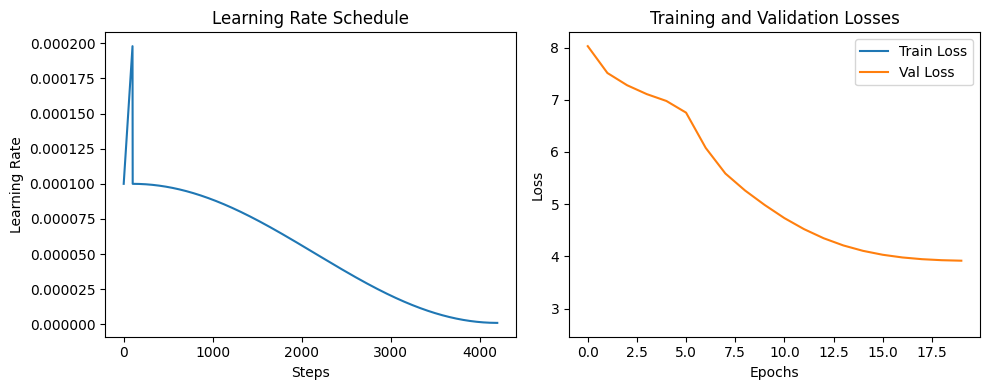

In [ ]:
# FOR EPOCH 1

import torch.optim as optim # Import the optim module from torch
import matplotlib.pyplot as plt # Import matplotlib for plotting
# Hyperparameters
n_epochs = 1
warmup_steps = 100
initial_lr = 1e-4
min_lr = 1e-6
eval_freq = 200
clip_value = 1.0
k = 5
temperature = 0.8

optimizer = optim.AdamW(model.parameters(), lr=initial_lr) # Now optim is defined
train_losses, val_losses, lr_values = train_model(
    model, train_loader, val_loader, optimizer,
    n_epochs=n_epochs,
    warmup_steps=warmup_steps,
    initial_lr=initial_lr,
    min_lr=min_lr,
    eval_freq=eval_freq,
    clip_value=clip_value,
    k=k,
    temperature=temperature
)

# Plotting Learning Rate and Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(lr_values)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Losses")

plt.tight_layout()
plt.show()

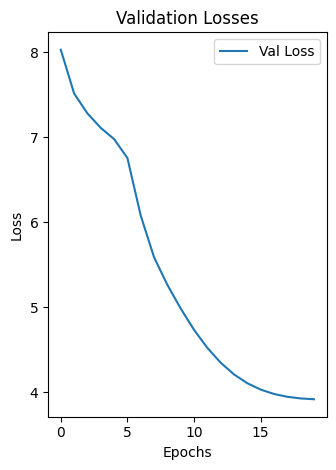

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Losses")

plt.tight_layout()
plt.show()

### Saving model checkpoint for the next epoch

In [12]:
import torch

def save_checkpoint(model, optimizer, epoch, lr_values, train_losses, val_losses, path="model_checkpoint_epoch2.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_values': lr_values,
        'train_losses': train_losses,
        'val_losses': val_losses,
        # Add model_config to the checkpoint
        'model_config': {
            'vocab_size': model.tok_emb.num_embeddings, # Access vocab_size from tok_emb
            'embed_size': model.tok_emb.embedding_dim, # Access embed_size from tok_emb
            'num_heads': config['n_heads'], # Access num_heads from the config
            'num_layers': config['n_layers'], # Access num_layers from the config
            'max_seq_len': config['context_length']  # Access max_seq_len (context_length) from config
        }
    }
    torch.save(checkpoint, path)
    print("Checkpoint saved successfully!")

# Save after training completes
save_checkpoint(model, optimizer, n_epochs, lr_values, train_losses, val_losses)

Checkpoint saved successfully!


### Inspect Checkpoint file

In [ ]:
# For Epoch 1

import torch

# Load the checkpoint
checkpoint_path = "model_checkpoint_epoch1.pth"
checkpoint = torch.load(checkpoint_path)

# Extract and print details
print("----- Checkpoint Details -----")
print(f"Last Completed Epoch: {checkpoint['epoch']}")
print(f"Total Training Steps: {checkpoint.get('step', 'N/A')}")
print(f"Current Learning Rate: {checkpoint['optimizer_state_dict']['param_groups'][0]['lr']}")
print(f"Training Loss at Save: {checkpoint.get('train_loss', 'N/A')}")
print(f"Validation Loss at Save: {checkpoint.get('val_loss', 'N/A')}")
print(f"Model Hyperparameters: {checkpoint['model_config']}")

# Check model state_dict keys
print("\n----- Model State Dict Keys -----")
print(list(checkpoint['model_state_dict'].keys()))


----- Checkpoint Details -----
Last Completed Epoch: 1
Total Training Steps: N/A
Current Learning Rate: 1.0000581539231629e-06
Training Loss at Save: N/A
Validation Loss at Save: N/A
Model Hyperparameters: {'vocab_size': 100277, 'embed_size': 256, 'num_heads': 16, 'num_layers': 16, 'max_seq_len': 1024}

----- Model State Dict Keys -----
['tok_emb.weight', 'pos_emb.weight', 'layers.0.attention.query.weight', 'layers.0.attention.query.bias', 'layers.0.attention.key.weight', 'layers.0.attention.key.bias', 'layers.0.attention.value.weight', 'layers.0.attention.value.bias', 'layers.0.attention.fc_out.weight', 'layers.0.attention.fc_out.bias', 'layers.0.norm1.scale', 'layers.0.norm1.shift', 'layers.0.ffn.net.0.weight', 'layers.0.ffn.net.0.bias', 'layers.0.ffn.net.2.weight', 'layers.0.ffn.net.2.bias', 'layers.0.norm2.scale', 'layers.0.norm2.shift', 'layers.1.attention.query.weight', 'layers.1.attention.query.bias', 'layers.1.attention.key.weight', 'layers.1.attention.key.bias', 'layers.1.atte

In [13]:
# For Epoch 2

import torch

# Load the checkpoint
checkpoint_path = "model_checkpoint_epoch2.pth"
checkpoint = torch.load(checkpoint_path)

# Extract and print details
print("----- Checkpoint Details -----")
print(f"Last Completed Epoch: {checkpoint['epoch']}")
print(f"Total Training Steps: {checkpoint.get('step', 'N/A')}")
print(f"Current Learning Rate: {checkpoint['optimizer_state_dict']['param_groups'][0]['lr']}")
print(f"Training Loss at Save: {checkpoint.get('train_loss', 'N/A')}")
print(f"Validation Loss at Save: {checkpoint.get('val_loss', 'N/A')}")
print(f"Model Hyperparameters: {checkpoint['model_config']}")

# Check model state_dict keys
print("\n----- Model State Dict Keys -----")
print(list(checkpoint['model_state_dict'].keys()))


----- Checkpoint Details -----
Last Completed Epoch: 1
Total Training Steps: N/A
Current Learning Rate: 1.0000581539231629e-06
Training Loss at Save: N/A
Validation Loss at Save: N/A
Model Hyperparameters: {'vocab_size': 100277, 'embed_size': 256, 'num_heads': 16, 'num_layers': 16, 'max_seq_len': 1024}

----- Model State Dict Keys -----
['tok_emb.weight', 'pos_emb.weight', 'layers.0.attention.query.weight', 'layers.0.attention.query.bias', 'layers.0.attention.key.weight', 'layers.0.attention.key.bias', 'layers.0.attention.value.weight', 'layers.0.attention.value.bias', 'layers.0.attention.fc_out.weight', 'layers.0.attention.fc_out.bias', 'layers.0.norm1.scale', 'layers.0.norm1.shift', 'layers.0.ffn.net.0.weight', 'layers.0.ffn.net.0.bias', 'layers.0.ffn.net.2.weight', 'layers.0.ffn.net.2.bias', 'layers.0.norm2.scale', 'layers.0.norm2.shift', 'layers.1.attention.query.weight', 'layers.1.attention.query.bias', 'layers.1.attention.key.weight', 'layers.1.attention.key.bias', 'layers.1.atte

### Load and Resume Training

Run Step 1 to 4 before running this cell, upload all the .pth files

In [8]:
import torch
import torch.optim as optim # Import the optim module from torch

# Define initial_lr here
initial_lr = 1e-4  # or any desired value

# Change the name of checkpoint file based on epoch number
def load_checkpoint(model, optimizer, path="model_checkpoint_epoch1.pth"):
    checkpoint = torch.load(path)

    # Load saved states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    lr_values = checkpoint['lr_values']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

    print(f"Checkpoint loaded. Resuming from epoch {epoch + 1}")
    return epoch, lr_values, train_losses, val_losses

# Create optimizer first
optimizer = optim.AdamW(model.parameters(), lr=initial_lr)

# Load model, optimizer, and states
start_epoch, lr_values, train_losses, val_losses = load_checkpoint(model, optimizer)


Checkpoint loaded. Resuming from epoch 2


In [9]:
# Before running this cell run the cell somewhere up where train_model() is defined

# This is for Epoch 2 ignore 1 in the output

n_epochs = 1
warmup_steps = 100
initial_lr = 1e-4
min_lr = 1e-6
eval_freq = 200
clip_value = 1.0
k = 5
temperature = 0.8

# Resume training from the loaded epoch
train_losses, val_losses, lr_values = train_model(
    model, train_loader, val_loader, optimizer,
    n_epochs=n_epochs,  # Continue from where left off
    warmup_steps=warmup_steps,
    initial_lr=initial_lr,
    min_lr=min_lr,
    eval_freq=eval_freq,
    clip_value=clip_value,
    k=k,
    temperature=temperature
)


Epoch 1, Step 200 | Val Loss: 3.6037
Epoch 1, Step 400 | Val Loss: 3.2421
Epoch 1, Step 600 | Val Loss: 2.9321
Epoch 1, Step 800 | Val Loss: 2.6534
Epoch 1, Step 1000 | Val Loss: 2.4047
Epoch 1, Step 1200 | Val Loss: 2.1908
Epoch 1, Step 1400 | Val Loss: 2.0107
Epoch 1, Step 1600 | Val Loss: 1.8526
Epoch 1, Step 1800 | Val Loss: 1.7190
Epoch 1, Step 2000 | Val Loss: 1.6131
Epoch 1, Step 2200 | Val Loss: 1.5230
Epoch 1, Step 2400 | Val Loss: 1.4480
Epoch 1, Step 2600 | Val Loss: 1.3906
Epoch 1, Step 2800 | Val Loss: 1.3450
Epoch 1, Step 3000 | Val Loss: 1.3111
Epoch 1, Step 3200 | Val Loss: 1.2845
Epoch 1, Step 3400 | Val Loss: 1.2670
Epoch 1, Step 3600 | Val Loss: 1.2555
Epoch 1, Step 3800 | Val Loss: 1.2489
Epoch 1, Step 4000 | Val Loss: 1.2455
Epoch 2 Training Loss: 0.9593


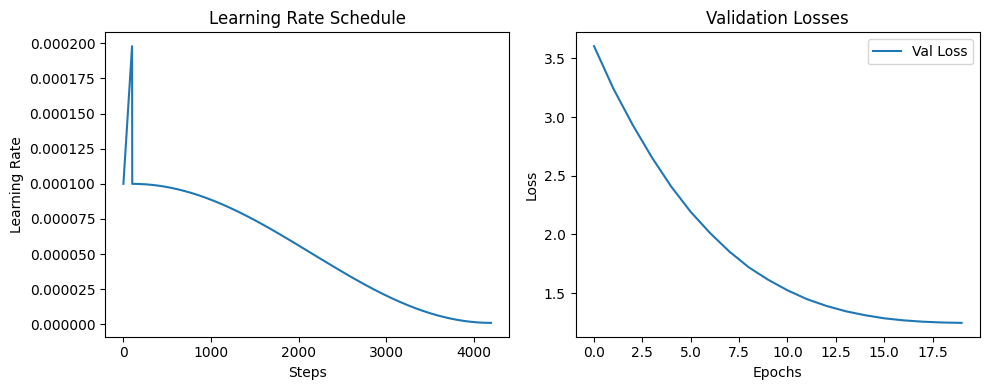

In [11]:
# Plotting Learning Rate and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(lr_values)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.subplot(1, 2, 2)
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Losses")

plt.tight_layout()
plt.show()

# Go to Step -> Saving model checkpoint for the next epoch
# No need to run Step -> Inspect Checkpoint as the output will be same for all other epochs except the learning rate (for which we have graph)

# Done upto epoch 2 since the desirable validation loss and training loss are achieved.
# If the wikipedia dataset (1390 articles/websites) is increased more epochs will do
# GPT2 by openai used 12 epochs for 8 million websites

### Save the Foundation Model

In [15]:
import torch

def save_foundation_model(model, save_path="foundation_model.pth"):
    # Save only essential information for inference
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'vocab_size': model.tok_emb.num_embeddings,  # Access vocab_size from tok_emb
            'embed_size': model.tok_emb.embedding_dim,  # Access embed_size from tok_emb
            'num_heads': config['n_heads'],  # Access num_heads from config
            'num_layers': config['n_layers'],  # Access num_layers from config
            'max_seq_len': config['context_length']  # Access context_length from config
        }
    }, save_path)
    print("Foundation model saved successfully.")

# Save After Training
save_foundation_model(model, save_path="foundation_model.pth")

Foundation model saved successfully.


### Load and use the model for inference

In [26]:
import torch
import torch.nn as nn

# Define the model class (as before)
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embed_size"])
        self.pos_emb = nn.Embedding(cfg["max_seq_len"], cfg["embed_size"])
        self.drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([
            TransformerBlock(cfg["embed_size"], cfg["num_heads"]) for _ in range(cfg["num_layers"])
        ])

        self.norm = LayerNorm(cfg["embed_size"])
        self.fc_out = nn.Linear(cfg["embed_size"], cfg["vocab_size"], bias=False)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        tok_emb = self.tok_emb(idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=idx.device))
        x = self.drop(tok_emb + pos_emb)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        logits = self.fc_out(x)
        return logits

# Function to load the model for inference
def load_foundation_model(checkpoint_path="foundation_model.pth"):
    checkpoint = torch.load(checkpoint_path)

    # Reconstruct model
    model_config = checkpoint['model_config']
    # Pass model_config as a dictionary
    model = GPTModel(model_config)

    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode
    print("Foundation model loaded for inference.")

    return model

# Load the model
model = load_foundation_model("foundation_model.pth")

# Example Inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sample input (tokenized text, replace with your tokenizer logic)
sample_input = torch.randint(0, 100277, (1, 20)).to(device)  # Batch of 1, Sequence length 20
with torch.no_grad():
    output = model(sample_input)
    predicted_tokens = torch.argmax(output, dim=-1)

print("Predicted Tokens:", predicted_tokens)

Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attent

### Validation Accuracy

In [31]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

# Load validation data from prepared_data_wiki.pth
def load_validation_data(file_path="prepared_data_wiki.pth"):
    train_data, val_data, embedding_weights = torch.load(file_path) # Load as a tuple

    # Convert val_data (list of lists) into a PyTorch tensor
    val_data = torch.tensor(val_data, dtype=torch.long)

    # Create labels by shifting the input data by one position
    val_labels = val_data[:, 1:]  # Targets are the next tokens in the sequence
    val_data = val_data[:, :-1]  # Inputs are the current tokens

    return val_data, val_labels  # Return validation data and labels

# Load validation data
val_data, val_labels = load_validation_data()

# Create DataLoader for validation
batch_size = 16
val_dataset = data.TensorDataset(val_data, val_labels) # val_data is now a tensor
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load trained model
def load_foundation_model(checkpoint_path="foundation_model.pth"):
    checkpoint = torch.load(checkpoint_path)

    # Reconstruct model
    model_config = checkpoint['model_config']
    # Pass model_config as a dictionary
    model = GPTModel(model_config)

    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode
    print("Foundation model loaded for inference.")

    return model

# Load foundation model
model = load_foundation_model("foundation_model.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to calculate validation accuracy
def calculate_validation_accuracy(model, val_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(inputs)
            predicted_tokens = torch.argmax(outputs, dim=-1)

            # Compare predictions to ground truth
            correct_predictions += (predicted_tokens == labels).sum().item()
            total_samples += labels.numel()

    accuracy = correct_predictions / total_samples * 100
    return accuracy

# Calculate and print validation accuracy
val_accuracy = calculate_validation_accuracy(model, val_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attent

## Model Specifications

In [32]:
try:
    import torchinfo
    print("✅ torchinfo is already installed.")
except ImportError:
    print("❌ torchinfo is NOT installed. Install it using: pip install torchinfo")
    !pip install torchinfo


❌ torchinfo is NOT installed. Install it using: pip install torchinfo


### Details

In [52]:
import torch
import torch.nn as nn
import torchinfo  # Ensure torchinfo is installed

# Load trained foundation model and display details
def load_foundation_model_with_details(checkpoint_path="foundation_model.pth"):
    checkpoint = torch.load(checkpoint_path)

    # Reconstruct model
    model_config = checkpoint['model_config']
    model = GPTModel(model_config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to('cuda')
    print("✅ Foundation model loaded for inference.")

    # Display model configuration
    print("\n🔍 Foundation Model Details:")
    print(f"📜 Vocabulary Size: {model_config['vocab_size']}")
    print(f"🟢 Embedding Size: {model_config['embed_size']}")
    print(f"🔗 Number of Heads: {model_config['num_heads']}")
    print(f"🔁 Number of Layers: {model_config['num_layers']}")
    print(f"📏 Max Sequence Length: {model_config['max_seq_len']}")

    # Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"💡 Total Parameters: {total_params:,}")
    print(f"✅ Trainable Parameters: {trainable_params:,}\n")

    # torchinfo usage
    try:
        sample_input = torch.zeros((1, model_config['max_seq_len']), dtype=torch.long)
        torchinfo.summary(
            model,
            input_data=sample_input,
            device='cuda',
            # depth=3,          # Control depth of layers to display
            # col_names=["output_size", "num_params"],  # Show output shape and parameter count
            # row_settings=["var_names"]  # Display layer variable names
        )
    except ImportError:
        print("⚠️ Install torchinfo for a detailed summary (pip install torchinfo)")

    print("\n✅ Model loaded successfully for validation!")
    return model

# Load and display
model = load_foundation_model_with_details("foundation_model.pth")


Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attent

In [62]:
import os
import torch
import torch.nn as nn
from tabulate import tabulate

# Function to manually create a summary table
def manual_model_summary(model, model_path="foundation_model.pth", data_path="prepared_data_wiki.pth"):
    # Load model size
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)

    # Load actual validation data
    data = torch.load(data_path)
    _, val_data, _ = data  # Access elements by index

    if isinstance(val_data, list):
        val_data = torch.tensor(val_data)

    actual_input = val_data[:1].long()

    # Prepare table
    table_data = []
    total_params = 0

    # Iterate through model layers
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Ignore containers
            # Calculate parameters
            params = sum(p.numel() for p in module.parameters())
            total_params += params

            # Determine output shape
            try:
                output_shape = list(module(actual_input).shape)
            except Exception:
                output_shape = ["N/A"]  # Skip if not forward-passable

            # ✅ Skip rows with "N/A" in Output Shape
            if output_shape != ["N/A"]:
                table_data.append([name, output_shape, params])

    # Add total parameters
    table_data.append(["Total", "-", total_params])

    # Print formatted table
    print("\n📊 Manual Model Summary")
    print(tabulate(table_data, headers=["Layer (type)", "Output Shape", "Param #"], tablefmt="fancy_grid"))
    print(f"\n💾 Model Size on Disk: {model_size_mb:.2f} MB")

# Load model
checkpoint = torch.load("foundation_model.pth")
model_config = checkpoint['model_config']
model = GPTModel(model_config)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Generate the manual table
manual_model_summary(model)


Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attent

### Model Size

In [55]:
import os
import torch
import torch.nn as nn
import torchinfo

def load_and_show_model_size(checkpoint_path="foundation_model.pth"):
    checkpoint = torch.load(checkpoint_path)

    # Reconstruct model
    model_config = checkpoint['model_config']
    # Pass model_config as a dictionary
    model = GPTModel(model_config)

    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode

    # ✅ Display model size
    model_size_mb = os.path.getsize(checkpoint_path) / (1024 * 1024)
    print(f"💾 Model Size on Disk: {model_size_mb:.2f} MB")

model = load_and_show_model_size("foundation_model.pth")


Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attention_mechanism.pth'...
Loading pretrained attention mechanism from 'attent

# ----------------- STAGE 2 ENDS ----------------------